In [51]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,RSI,RSI_Strategy,Average_Price,Money_Flow,Pos_Flow,Neg_Flow,MFI,MFI_Strategy,Full_Strategy,Strategy,Asset_Returns,Strategy_Returns
26,152.089996,152.770004,136.600998,138.169998,400200,63.963142,0.0,147.153666,5.889090e+07,147.153666,0.000000,47.184661,NaN,NaN,0,NaN,NaN
27,163.059998,163.839996,146.561005,149.000000,316100,71.684698,0.0,157.820333,4.988701e+07,157.820333,0.000000,51.727382,0.0,0.0,0,0.072128,0.000000
28,163.380005,164.830002,158.020004,164.830002,226300,73.543314,-1.0,162.076670,3.667795e+07,162.076670,0.000000,59.645750,0.0,-1.0,0,0.074232,0.000000
29,158.110001,163.580002,153.660004,163.380005,230600,69.920645,-1.0,158.450002,3.653857e+07,0.000000,158.450002,58.796372,0.0,-1.0,0,0.039582,0.000000
30,169.750000,170.580002,155.014999,156.729996,205900,79.819394,0.0,165.115000,3.399718e+07,165.115000,0.000000,66.212320,0.0,0.0,0,0.116115,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
952,531.460022,536.870972,514.804993,519.359985,823900,97.876874,-1.0,527.711995,4.347819e+08,527.711995,0.000000,86.198796,-1.0,-2.0,-1,2.494379,-0.190975
953,540.679993,544.929993,532.562012,536.150024,841300,97.928471,-1.0,539.390666,4.537894e+08,539.390666,0.000000,86.550963,-1.0,-2.0,-1,2.555000,-0.205011
954,530.520020,541.460022,527.000000,536.000000,751900,92.200721,-1.0,532.993347,4.007577e+08,0.000000,532.993347,78.819003,-1.0,-2.0,-1,2.488198,-0.190072
955,529.049988,536.000000,522.260010,525.000000,694900,91.315012,-1.0,529.103333,3.676739e+08,0.000000,529.103333,71.459258,-1.0,-2.0,-1,2.478532,-0.187828


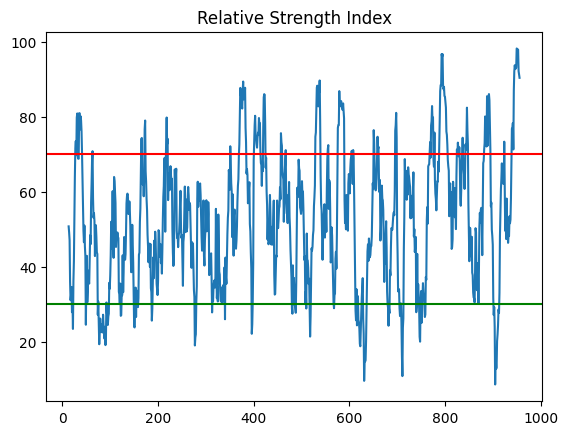

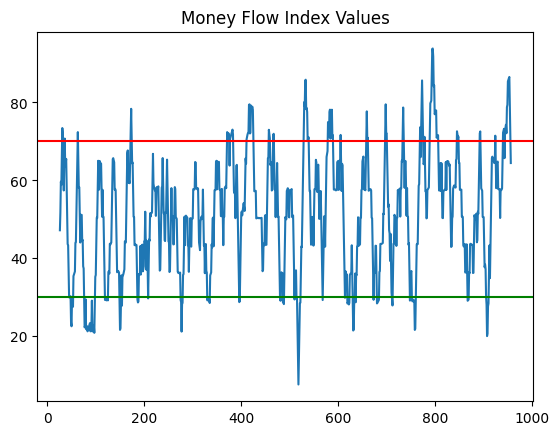

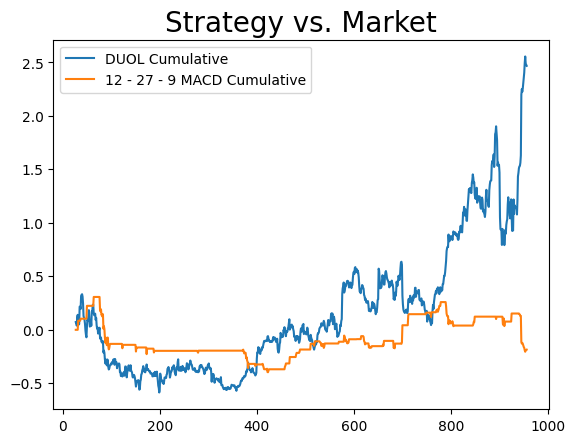

In [ ]:
TICKER = 'DUOL'
INTERVAL='1d'

# set period based on interval
if INTERVAL == '1h':
    PERIOD = '730d'
else:
    PERIOD = 'max'

RSI_LENGTH = 14
MFI_LENGTH = 14
MFI_OVERBOUGHT = 70
MFI_OVERSOLD = 30
RSI_OVERBOUGHT = 70
RSI_OVERSOLD = 30

# what subsetion of that data are you interested in
LOOKBACK = 10000

def get_data(ticker=TICKER, lookback=LOOKBACK, interval=INTERVAL):

    # get data at interval you want
    df = yf.download(ticker, interval=interval, period=PERIOD)
    df.columns = df.columns.get_level_values(0)

    # reset the index to make plots prettier
    df = df.reset_index(drop=True)

    # only return the subset of data you are interested in
    return df.iloc[-lookback:, :]

def add_RSI(df, length=RSI_LENGTH, overbought=RSI_OVERBOUGHT, oversold=RSI_OVERSOLD):

    price_change = df['Close'].diff()
    
    # separate gains/losses
    gain = price_change.where(price_change > 0, 0)
    loss = -price_change.where(price_change < 0, 0)

    # average gain vs loss
    avg_gain = gain.rolling(window=length).mean()
    avg_loss = loss.rolling(window=length).mean()

    # calculate rsi
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    df['RSI'] = rsi

    # plot the relative strength index
    plt.plot(df['RSI'])
    plt.axhline(overbought, color='red')
    plt.axhline(oversold, color='green')
    plt.title('Relative Strength Index')

    return df.dropna()

def add_RSI_strategy(df, overbought=RSI_OVERBOUGHT, oversold=RSI_OVERSOLD):

    df['RSI_Strategy'] = 0
    df['RSI_Strategy'] = np.where(df['RSI'] > overbought, -1, 
                     np.where(df['RSI'] < oversold, 1, 0))
    
    # shift back to make sure we have seen the signal
    df['RSI_Strategy'] = df['RSI_Strategy'].shift(1)
    return df

def add_MFI(df, length=MFI_LENGTH, overbought=MFI_OVERBOUGHT, oversold=MFI_OVERSOLD):

    df['Average_Price'] = (df['High'] + df['Low'] + df['Close']) / 3
    df['Money_Flow'] = df['Volume'] * df['Average_Price']
 
    # initialize empty flows
    df['Pos_Flow'] = 0
    df['Neg_Flow'] = 0

    df['Pos_Flow'] = np.where(df['Average_Price'].diff() > 0, df['Average_Price'], 0)
    df['Neg_Flow'] = np.where(df['Average_Price'].diff() < 0, df['Average_Price'], 0)

    mfr = df['Pos_Flow'].rolling(length).sum() / df['Neg_Flow'].rolling(length).sum()

    # add money flow column
    df['MFI'] = 100 - (100 / (1 + mfr))

    plt.figure()
    plt.plot(df['MFI'])
    plt.axhline(overbought, color='red')
    plt.axhline(oversold, color='green')
    plt.title('Money Flow Index Values');
        
    return df.dropna()

def add_MFI_strategy(df, overbought=MFI_OVERBOUGHT, oversold=MFI_OVERSOLD):

    df['MFI_Strategy'] = 0
    df['MFI_Strategy'] = np.where(df['MFI'] > overbought, -1, 
                     np.where(df['MFI'] < oversold, 1, 0))
    
    # shift back to make sure we have seen the signal
    df['MFI_Strategy'] = df['MFI_Strategy'].shift(1)
    return df

def add_full_strategy(df):

    df['Full_Strategy'] = df['RSI_Strategy'] + df['MFI_Strategy']

    # adjust values for simplicity
    df['Strategy'] = np.where(df['Full_Strategy'] == 2, 1, 
                     np.where(df['Full_Strategy'] == -2, -1, 0))

    return df

def test_strategy(df):

    df['Asset_Returns'] = (1 + df['Close'].pct_change()).cumprod() - 1
    df['Strategy_Returns'] = (1 + df['Close'].pct_change() * df['Strategy']).cumprod() -1

    plt.figure()
    plt.plot(df['Asset_Returns'])
    plt.plot(df['Strategy_Returns'])
    plt.legend([f'{TICKER} Cumulative', f'{MACD_FAST} - {MACD_SLOW} - {MACD_SPAN} MACD Cumulative'])
    plt.title('Strategy vs. Market', size='20')

    return df

def main():
    df = get_data()
    df = add_RSI(df)
    df = add_RSI_strategy(df)
    df = add_MFI(df)
    df = add_MFI_strategy(df)
    df = add_full_strategy(df)
    df = test_strategy(df)

    return df

df = main()

df